In [2]:
    pip install pandas

  Using cached pandas-2.3.3-cp39-cp39-macosx_11_0_arm64.whl (10.8 MB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
You should consider upgrading via the '/Users/intesurahmed/Documents/763/.env_assignment3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install matplotlib
    

  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_11_0_arm64.whl (4.7 MB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached fonttools-4.60.1-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
You should consider upgrading via the '/Users/intesurahmed/Documents/763/.env_assignment3/bin/python3 -m pip install --upgrade pip' command.


In [8]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
You should consider upgrading via the '/Users/intesurahmed/Documents/763/.env_assignment3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install scipy

  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)
You should consider upgrading via the '/Users/intesurahmed/Documents/763/.env_assignment3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind # For differential expression on log2 FPKM
from scipy.stats import false_discovery_control # For FDR correction
import warnings
warnings.filterwarnings("ignore") # Suppress potential warnings for cleaner output

##### Downloaded "GSE183947_fpkm.csv.gz" file, then used gunzip command to decompress the file "GSE183947_fpkm.csv" in the same dir
##### Loading the data Using Python Script

In [25]:
fpkm_df = pd.read_csv('GSE183947_fpkm.csv', index_col=0) # Adjust path if needed

In [26]:
print("FPKM Data Shape:", fpkm_df.shape)
print("First few rows and columns:")
print(fpkm_df.iloc[:5, :5])

FPKM Data Shape: (20246, 60)
First few rows and columns:
          CA.102548  CA.104338  CA.105094  CA.109745  CA.1906415
TSPAN6         0.93       1.97       0.00       5.45        4.52
TNMD           0.00       0.00       0.00       0.00        0.00
DPM1           0.00       0.43       0.00       3.43        8.45
SCYL3          5.78       5.17       8.76       4.58        7.20
C1orf112       2.83       6.26       3.37       6.24        5.16


#### Need to map each sample column name (likely GSM numbers) to its condition (Normal/Cancer).
#### The GEO page states "30 pairs of normal and cancerous tissues".
#### Need the sample names from FPKM file (columns) and match them to Normal/Cancer status.
#### This information is usually in the SRA/BioProject metadata or sometimes in a separate file.
#### Let's assume the first 30 columns are Normal and the next 30 are Cancer (based on 30 pairs).
#### IMPORTANT: MUST VERIFY THIS AGAINST GEO/SRA METADATA OR THE PAPER'S SUPPLEMENTARY INFO.

In [27]:
sample_names = fpkm_df.columns.tolist()
num_samples = len(sample_names)
num_normal = 30 # Based on "30 pairs"
num_cancer = 30 # Based on "30 pairs"

In [28]:
# Verify the number of samples matches the expected design
if num_samples != (num_normal + num_cancer):
    print(f"Warning: Expected {num_normal + num_cancer} samples based on 30 pairs, but found {num_samples}. Check sample file.")
    # Might need to filter the data if there are extra columns (e.g., for controls not part of the main comparison)
    # For now, let's proceed assuming the first 30 are Normal and the rest are Cancer, if total is 60.
elif num_samples == 60:
    print("Sample count matches 30 pairs (60 samples). Proceeding.")
else:
    raise ValueError(f"Unexpected sample count: {num_samples}. Expected 60 for 30 pairs.")

Sample count matches 30 pairs (60 samples). Proceeding.


In [29]:
# Assign conditions based on the known design (first 30 Normal, next 30 Cancer)
# This is a critical assumption that needs verification!
conditions = ['Normal'] * num_normal + ['Cancer'] * num_cancer

if len(conditions) != len(sample_names):
    raise ValueError("Number of conditions does not match number of samples in the FPKM file.")

# Create the sample information DataFrame
sample_info = pd.DataFrame({'condition': conditions}, index=sample_names)

print("\nSample Information:")
print(sample_info.head(10))
print("\nCondition Counts:")
print(sample_info['condition'].value_counts())


Sample Information:
           condition
CA.102548     Normal
CA.104338     Normal
CA.105094     Normal
CA.109745     Normal
CA.1906415    Normal
CA.1912627    Normal
CA.1924346    Normal
CA.1926760    Normal
CA.1927842    Normal
CA.1933414    Normal

Condition Counts:
condition
Normal    30
Cancer    30
Name: count, dtype: int64


##### Perform Differential Expression Analysis on log2(FPKM+1) ---
##### FPKM is normalized, so we often log-transform it (e.g., log2(FPKM + 1)) for analysis.
##### Adding a small pseudocount (like 1) avoids log(0).

In [30]:
log2_fpkm_df = np.log2(fpkm_df + 1)

print("\nLog2(FPKM+1) Data Shape:", log2_fpkm_df.shape)



Log2(FPKM+1) Data Shape: (20246, 60)


In [40]:
# Perform a simple statistical test (e.g., t-test) for each gene
# Get sample indices for each group
normal_samples = sample_info[sample_info['condition'] == 'Normal'].index
cancer_samples = sample_info[sample_info['condition'] == 'Cancer'].index

# Prepare lists to store results
p_values = []
log2_fold_changes = []
processed_genes = [] # Keep track of genes actually processed


In [41]:
for gene in log2_fpkm_df.index:
    # Extract expression values for the current gene in each group
    expr_normal = log2_fpkm_df.loc[gene, normal_samples]
    expr_cancer = log2_fpkm_df.loc[gene, cancer_samples]

    # Check for edge cases: constant values in a group (std=0) or insufficient data
    # Also check if any values are NaN
    if (expr_normal.std() == 0 or expr_cancer.std() == 0 or
        len(expr_normal) < 2 or len(expr_cancer) < 2 or
        expr_normal.isna().any() or expr_cancer.isna().any()):
        # Assign a non-significant p-value and zero fold change if data is insufficient, constant, or contains NaN
        p_values.append(1.0)
        log2_fold_changes.append(0.0)
        processed_genes.append(gene)
        continue

    # Perform t-test (assumes normal distribution of log-values)
    t_stat, p_val = ttest_ind(expr_cancer, expr_normal, equal_var=False) # Welch's t-test

    # Handle potential NaN or inf p-values from ttest_ind
    if np.isnan(p_val) or np.isinf(p_val):
        p_values.append(1.0) # Treat as non-significant
    else:
        # Ensure p-value is within [0, 1] range, clip if necessary
        p_val_clipped = np.clip(p_val, 0.0, 1.0)
        p_values.append(p_val_clipped)

    # Calculate log2 fold change (mean_cancer - mean_normal)
    mean_cancer = expr_cancer.mean()
    mean_normal = expr_normal.mean()
    log2_fc = mean_cancer - mean_normal
    log2_fold_changes.append(log2_fc)
    processed_genes.append(gene) # Add gene name to the list of processed genes


In [42]:
# Verify the lengths match the original index
if len(processed_genes) != len(log2_fpkm_df.index):
    print(f"Warning: Processed {len(processed_genes)} genes, but original data had {len(log2_fpkm_df.index)}.")
    print("This might be due to rows with all NaN values in the original FPKM file that were handled differently.")
    # If lengths don't match, filter the log2_fpkm_df to only include processed genes for downstream analysis
    # This is the safer approach to ensure alignment
    log2_fpkm_df_filtered = log2_fpkm_df.loc[processed_genes]
    print(f"Filtered log2_fpkm_df to {len(log2_fpkm_df_filtered)} genes for consistency.")
else:
    print(f"All {len(log2_fpkm_df.index)} genes were processed successfully.")
    log2_fpkm_df_filtered = log2_fpkm_df # Use original if all processed

# Create results DataFrame using the list of processed genes as the index
res_df = pd.DataFrame({
    'log2FoldChange': log2_fold_changes,
    'pvalue': p_values,
}, index=processed_genes) # Use processed_genes as the index


All 20246 genes were processed successfully.


In [43]:
# --- Apply Manual Benjamini-Hochberg for FDR correction ---
def benjamini_hochberg(p_vals):
    """
    Perform Benjamini-Hochberg FDR correction.
    Args:
        p_vals: array-like of p-values.
    Returns:
        Array of adjusted p-values (padj).
    """
    p_vals = np.asarray(p_vals)
    n = len(p_vals)
    # Get indices that would sort the p-values
    sorted_indices = np.argsort(p_vals)
    sorted_p_vals = p_vals[sorted_indices]

    # Calculate raw adjusted p-values (starting from the largest p-value)
    sorted_padj = np.empty(n)
    sorted_padj[n-1] = sorted_p_vals[n-1] # Last (largest) adjusted p-value is the raw p-value
    for i in range(n-2, -1, -1): # Go backwards from n-2 to 0
        # Adjusted p-value is the minimum of the previous adj_pval and the current raw calculation
        sorted_padj[i] = min(sorted_p_vals[i] * n / (i + 1), sorted_padj[i+1])

    # Restore the original order of the adjusted p-values
    padj = np.empty(n)
    padj[sorted_indices] = sorted_padj
    return padj

In [44]:
# Apply the manual BH correction
res_df['padj'] = benjamini_hochberg(res_df['pvalue'])

# Add significance column
alpha = 0.05
res_df['significant'] = (
    (res_df['padj'] < alpha) &
    (res_df['log2FoldChange'].abs() >= 1)  # |log2FC| >= 1
)


In [45]:
print("\nDifferential Expression Results (Top 10 based on adjusted p-value):")
print(res_df.sort_values('padj').head(10))

print("\nSummary of Results:")
print(f"Total Genes Tested: {len(res_df)}")
print(f"Significant Genes (padj < {alpha}, |log2FC| >= 1): {res_df['significant'].sum()}")
print(f"Upregulated (Cancer > Normal): {((res_df['padj'] < alpha) & (res_df['log2FoldChange'] >= 1)).sum()}")
print(f"Downregulated (Cancer < Normal): {((res_df['padj'] < alpha) & (res_df['log2FoldChange'] <= -1)).sum()}")
print(f"Genes with padj == 1.0 (potentially due to constant values, failed tests, or NaN): {(res_df['padj'] == 1.0).sum()}")


Differential Expression Results (Top 10 based on adjusted p-value):
         log2FoldChange        pvalue          padj  significant
CCDC177        3.530750  4.056647e-29  8.213088e-25         True
DEFB130        3.941893  2.178467e-22  2.205262e-18         True
UGT2A1         2.229926  4.567050e-22  2.395516e-18         True
KLK9           3.420770  4.732819e-22  2.395516e-18         True
TMEM239        1.940228  4.197483e-20  1.699645e-16         True
LCN6           3.531396  1.463142e-19  4.937130e-16         True
MDGA2          2.752373  4.464655e-19  1.291306e-15         True
MFRP           2.229932  2.883381e-18  7.297116e-15         True
ZNF788         1.467290  1.459060e-17  3.282236e-14         True
MYBL2         -2.850007  7.350299e-17  1.488142e-13         True

Summary of Results:
Total Genes Tested: 20246
Significant Genes (padj < 0.05, |log2FC| >= 1): 1795
Upregulated (Cancer > Normal): 871
Downregulated (Cancer < Normal): 924
Genes with padj == 1.0 (potentially due to c

#### --- Draw Volcano Plot and MA Plot ---

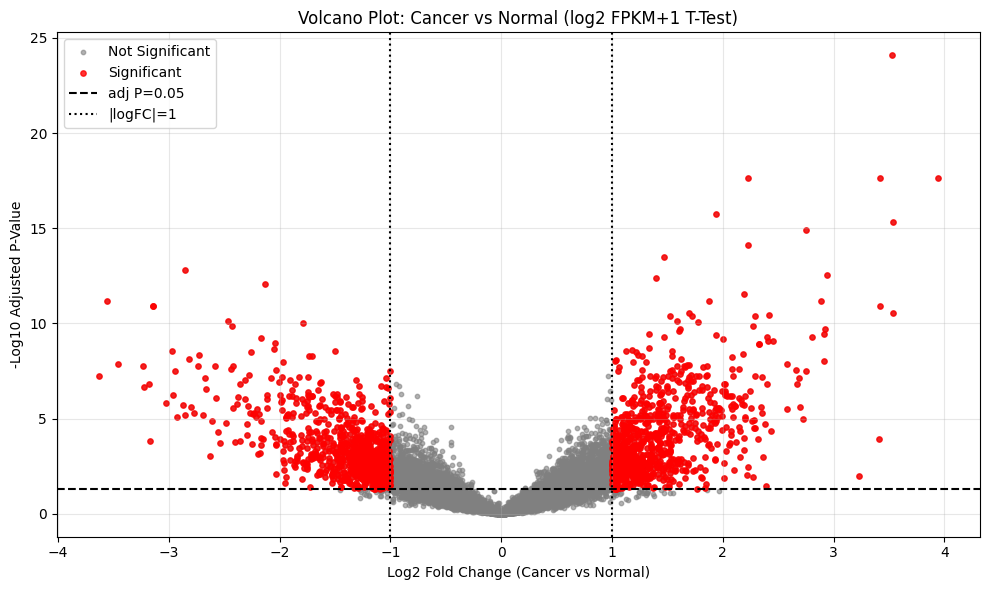

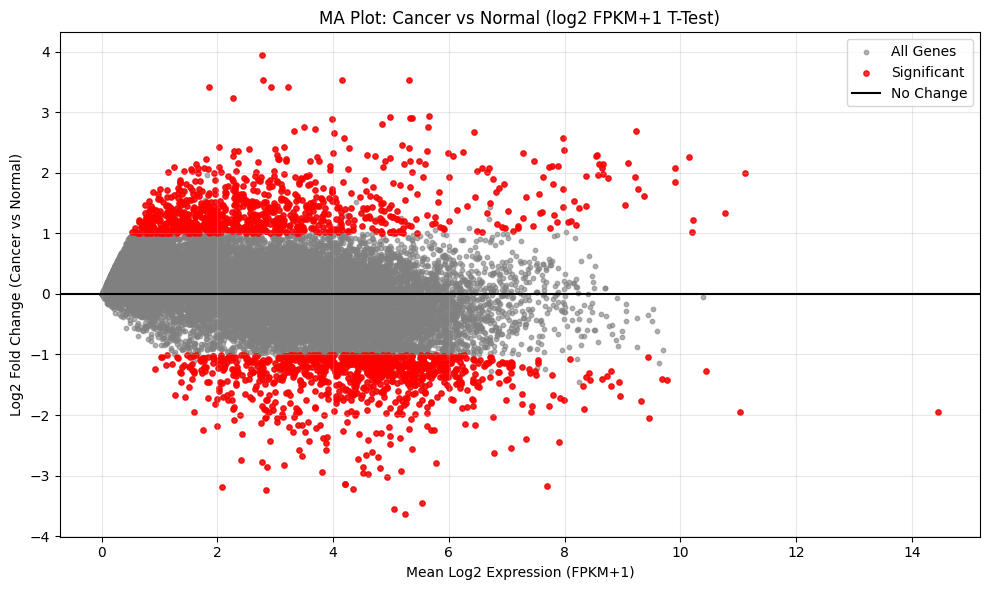

In [47]:
# --- Step 4: Draw Volcano Plot and MA Plot ---
if not res_df.empty:
    # Volcano Plot: -log10(padj) vs log2FoldChange
    plt.figure(figsize=(10, 6))
    # Plot all genes
    plt.scatter(
        res_df['log2FoldChange'],
        -np.log10(res_df['padj']),
        c='grey', alpha=0.6, s=10, label='Not Significant'
    )
    # Create sig_genes DataFrame AFTER all columns are added to res_df
    sig_genes = res_df[res_df['significant']]
    if not sig_genes.empty:
        plt.scatter(
            sig_genes['log2FoldChange'],
            -np.log10(sig_genes['padj']),
            c='red', alpha=0.8, s=15, label='Significant'
        )
    plt.axhline(y=-np.log10(alpha), color='black', linestyle='--', label=f'adj P={alpha}')
    plt.axvline(x=1, color='black', linestyle=':', label='|logFC|=1')
    plt.axvline(x=-1, color='black', linestyle=':')
    plt.xlabel('Log2 Fold Change (Cancer vs Normal)')
    plt.ylabel('-Log10 Adjusted P-Value')
    plt.title('Volcano Plot: Cancer vs Normal (log2 FPKM+1 T-Test)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()   
    # MA Plot for log2 FPKM  Mean expression vs log2 Fold Change
    # Calculate mean log2 expression for each gene across all samples using the filtered data
    # Use the filtered data if it was created, otherwise use the original
    mean_expr_values = log2_fpkm_df_filtered.mean(axis=1)
    res_df['mean_log2_expression'] = mean_expr_values # Assign calculated means to the results DataFrame

    plt.figure(figsize=(10, 6))
    plt.scatter(
        res_df['mean_log2_expression'],
        res_df['log2FoldChange'],
        c='grey', alpha=0.6, s=10, label='All Genes'
    )
    # Recreate sig_genes DataFrame to ensure it has the new 'mean_log2_expression' column
    sig_genes = res_df[res_df['significant']] # This line was moved up for the volcano plot too, but let's recreate it here for clarity if needed
    # Highlight significant genes (sig_genes now definitely has 'mean_log2_expression')
    if not sig_genes.empty:
        plt.scatter(
            sig_genes['mean_log2_expression'],
            sig_genes['log2FoldChange'],
            c='red', alpha=0.8, s=15, label='Significant'
        )
    plt.axhline(y=0, color='black', linestyle='-', label='No Change')
    plt.xlabel('Mean Log2 Expression (FPKM+1)')
    plt.ylabel('Log2 Fold Change (Cancer vs Normal)')
    plt.title('MA Plot: Cancer vs Normal (log2 FPKM+1 T-Test)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

####  --- Downstream Analysis (Enrichment/Pathway Analysis) ---

In [48]:
if not res_df.empty:
    significant_genes = res_df[res_df['significant']].copy() # Use res_df which now has all columns
    significant_genes = significant_genes.sort_values(by='padj') # Sort by adjusted p-value

    print("\nTop 20 Significant Genes (sorted by adjusted p-value):")
    print(significant_genes[['log2FoldChange', 'pvalue', 'padj']].head(20))

    # Prepare gene lists for external analysis (e.g., DAVID, GSEA)
    # Upregulated genes
    up_genes = significant_genes[significant_genes['log2FoldChange'] > 0].index.tolist()
    # Downregulated genes
    down_genes = significant_genes[significant_genes['log2FoldChange'] < 0].index.tolist()

    print(f"\nList of {len(up_genes)} Upregulated Gene IDs (for DAVID/GSEA):")
    print(up_genes[:10], "...") # Print first 10 for preview

    print(f"\nList of {len(down_genes)} Downregulated Gene IDs (for DAVID/GSEA):")
    print(down_genes[:10], "...") # Print first 10 for preview

    # Optional: Save the full results and significant gene lists to files
    res_df.to_csv('GSE183947_differential_expression_results_fpkm.csv')
    significant_genes.to_csv('GSE183947_significant_genes_fpkm.csv')
    with open('GSE183947_upregulated_genes_fpkm.txt', 'w') as f:
        f.write('\n'.join(up_genes))
    with open('GSE183947_downregulated_genes_fpkm.txt', 'w') as f:
        f.write('\n'.join(down_genes))

    print("\nResults saved to CSV and TXT files.")

    print("\n--- Downstream Analysis Guidance ---")
    print("To perform functional annotation/enrichment/pathway analysis:")
    print("1. Use the generated gene lists (upregulated/downregulated) as input.")
    print("2. Upload gene lists to online tools like:")
    print("   - DAVID (david.ncifcrf.gov)")
    print("   - Enrichr (maayanlab.cloud/Enrichr)")
    print("   - GSEA (software.broadinstitute.org/gsea/index.jsp) - Can also use ranked gene list (e.g., based on -log10(padj) * sign(log2FC))")
    print("3. Or use Python/R packages like gseapy (requires a ranked gene list), clusterprofiler (requires R/rpy2).")
    print("   - For gseapy: You can rank genes by a metric like -log10(padj) * sign(log2FC).")
    print("Choose the method that best suits your environment and requirements.")

else:
    print("\n--- Downstream Analysis ---")
    print("Differential expression analysis failed or produced no results. Cannot proceed with downstream analysis.")
    print("Please check the input data file and sample condition mapping.")



Top 20 Significant Genes (sorted by adjusted p-value):
          log2FoldChange        pvalue          padj
CCDC177         3.530750  4.056647e-29  8.213088e-25
DEFB130         3.941893  2.178467e-22  2.205262e-18
KLK9            3.420770  4.732819e-22  2.395516e-18
UGT2A1          2.229926  4.567050e-22  2.395516e-18
TMEM239         1.940228  4.197483e-20  1.699645e-16
LCN6            3.531396  1.463142e-19  4.937130e-16
MDGA2           2.752373  4.464655e-19  1.291306e-15
MFRP            2.229932  2.883381e-18  7.297116e-15
ZNF788          1.467290  1.459060e-17  3.282236e-14
MYBL2          -2.850007  7.350299e-17  1.488142e-13
SOX7            2.941502  1.582223e-16  2.912152e-13
TMEM236         1.394497  2.570303e-16  4.336530e-13
E2F1           -2.128108  5.486070e-16  8.543921e-13
ABCA8           2.191951  1.869275e-15  2.703239e-12
SOGA3           1.876966  4.910591e-15  6.474116e-12
OC90            2.882673  5.413662e-15  6.474116e-12
MMP11          -3.558343  5.436134e-15  6.4